In [1]:
import pandas as pd

#### This notebook is for me to remove short rows from the CAPS doctors' notes. Later I prep the samples for the data extraction use case

In [ ]:
# reading in the data
df = pd.read_csv("../Data/share.csv")

/tmp/ipykernel_402150/4204364814.py:3: DtypeWarning: Columns (0,72,73,74,79,80,81,82,83,84,93,94,95,99,101,102,103,105,106,107,108,109,110,131,144,146,148,156,162,164,166,169,170,171,173,174,176,177,178,179,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,227,228,229,230,231,232,249,264,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,287,288,291,292,293,365,366,367,368,369,370,371,372,373,430,431) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/share.csv')


In [ ]:
# Checkiing what columns exist
df.columns

Index(['NarrativeText', 'ID'], dtype='object')

In [ ]:
# Removing all rows from df that have a NaN value in the 'NarrativeText' column, or rows where there are less than five words in the column

df = df.dropna(subset=["NarrativeText"])

df = df[df["NarrativeText"].str.split().str.len() > 4]

# Now dropping all duplicate rows from the cleaned data, only paying attention to the 'NarrativeText' column

df = df.drop_duplicates(subset=["NarrativeText"])

# Checking the number of rows in the cleaned data
print(len(df))

297169


In [ ]:
# Saving the cleaned data to a new csv file

df.to_csv("../Data/cleaned_share.csv", index=False)

#### Below is code I use to prep the samples for the data extraction use case

In [ ]:
# Reading in the sample data for few-shot learning

samples = pd.read_csv("../Data/labled_samples.csv")

samples.head()

samples.columns

Index(['gen-anonymized', 'past_thoughts_about_death',
       'past_thoughts_about_ways_to_die', 'past_attempts_to_try_to_die',
       'past_hospitalizations_because_of_SI_or_SA',
       'how_recent_in_the_past_week_were_thoughts_about_death',
       'how_recent_in_the_past_week_were_thoughts_about_ways_to_die',
       'how_recent_in_the_past_week_were_past_attempts_to_try_to_die',
       'how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA',
       'current_thoughts_about_death', 'current_thoughts_about_ways_to_die',
       'current_intent_to_try_to_die',
       'client_acquiring_means_to_try_to_kill_themselves',
       'cooccuring_mental_health_symptoms', 'pornography_use',
       'anger_aggression_irritability', 'possibility_of_being_fired_expelled',
       'loss_of_major_relationship',
       'death_of_close_relationship_esp_from_suicide', 'fear_of_punishment',
       'anticipated_loss_of_financial_security',
       'fear_of_becoming_burden_to_others', '?Self_critical

In [ ]:
# Seeing how many rows with current_intent_to_try_to_die

print(len(samples[samples["current_intent_to_try_to_die"] == 1]))

# Seeing how many rows with current_thoughts_about_death

print(len(samples[samples["current_thoughts_about_death"] == 1]))

2
17


In [ ]:
# randomly selecting 4 rows without current_intent_to_try_to_die and 2 rows with it, and two rows with current_thoughts_about_death
# so I can use these in few-shot learning
import numpy as np

np.random.seed(0)

no_intent = samples[samples["current_intent_to_try_to_die"] == 0].sample(4)
intent = samples[samples["current_intent_to_try_to_die"] == 1]
thoughts = samples[samples["current_thoughts_about_death"] == 1].sample(2)

# combining the three dataframes

samples = pd.concat([no_intent, intent, thoughts])

samples

,gen-anonymized,past_thoughts_about_death,past_thoughts_about_ways_to_die,past_attempts_to_try_to_die,past_hospitalizations_because_of_SI_or_SA,how_recent_in_the_past_week_were_thoughts_about_death,how_recent_in_the_past_week_were_thoughts_about_ways_to_die,how_recent_in_the_past_week_were_past_attempts_to_try_to_die,how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA,current_thoughts_about_death,...,possibility_of_being_fired_expelled,loss_of_major_relationship,death_of_close_relationship_esp_from_suicide,fear_of_punishment,anticipated_loss_of_financial_security,fear_of_becoming_burden_to_others,?Self_critical_thoughts?,?Frustration?,?Conflict_with_close_relationship?,?Physical_pain?
45,xxxx began the session by explaining how bad h...,1,1,0,0,past week,past week,NaN,NaN,0,...,0,0,0,0,0,0,0,1,1,0
28,Client came in and began to talk about her wee...,0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,1,0
29,Client began session by talking about a relati...,0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,0,0,1,0,0,1,0,0,0
55,SUICIDE ASSESSMENT: MEANS: xxxx described imag...,1,1,0,0,NaN,NaN,NaN,NaN,1,...,0,0,0,1,0,0,1,0,0,0
59,Clinician met with pt for second appointment p...,1,1,1,0,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,0
66,xxxx reported that he was feeling overwhelmed ...,1,1,0,0,NaN,NaN,NaN,NaN,1,...,1,1,0,1,1,0,0,0,1,0
48,xxxx arrived on time for our appointment. His...,0,0,0,0,NaN,NaN,NaN,NaN,1,...,0,0,0,0,0,0,1,0,0,1
62,Zach reported that he had a good weekend with ...,1,1,0,0,occasionally,Once,NaN,NaN,1,...,0,1,0,0,0,0,1,0,0,0


Now there is the issue of having all of these columns about recent hospitalizations and such. There is non-finite number of answers to these questions, so what I am going to do is just create a index variable that looks for whether the answer to any of those questions was not null. To do that I am just going to throw away those columns and leave the new one

In [ ]:
# Create a new column called 'recency' that looks for whether any of the columns that start with 'how_recent' have a value that is not nan

samples["recency"] = samples.filter(like="how_recent").notna().any(axis=1)

# change recency column to 1s and 0s

samples["recency"] = samples["recency"].astype(int)

# move the columns that contain 'how_recent' in the name to the end of the dataframe

# Identify columns that contain 'how_recent'
how_recent_cols = [col for col in samples.columns if "how_recent" in col]

# Identify columns that do not contain 'how_recent'
other_cols = [col for col in samples.columns if "how_recent" not in col]

# Reorder the DataFrame columns
samples = samples[other_cols + how_recent_cols]

# Display the first few rows of the DataFrame
samples

,gen-anonymized,past_thoughts_about_death,past_thoughts_about_ways_to_die,past_attempts_to_try_to_die,past_hospitalizations_because_of_SI_or_SA,current_thoughts_about_death,current_thoughts_about_ways_to_die,current_intent_to_try_to_die,client_acquiring_means_to_try_to_kill_themselves,cooccuring_mental_health_symptoms,...,fear_of_becoming_burden_to_others,?Self_critical_thoughts?,?Frustration?,?Conflict_with_close_relationship?,?Physical_pain?,recency,how_recent_in_the_past_week_were_thoughts_about_death,how_recent_in_the_past_week_were_thoughts_about_ways_to_die,how_recent_in_the_past_week_were_past_attempts_to_try_to_die,how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA
45,xxxx began the session by explaining how bad h...,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,past week,past week,NaN,NaN
28,Client came in and began to talk about her wee...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
29,Client began session by talking about a relati...,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
55,SUICIDE ASSESSMENT: MEANS: xxxx described imag...,1,1,0,0,1,1,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
59,Clinician met with pt for second appointment p...,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
66,xxxx reported that he was feeling overwhelmed ...,1,1,0,0,1,1,1,1,1,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
48,xxxx arrived on time for our appointment. His...,0,0,0,0,1,0,0,0,1,...,0,1,0,0,1,0,NaN,NaN,NaN,NaN
62,Zach reported that he had a good weekend with ...,1,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,occasionally,Once,NaN,NaN


In [ ]:
# adding a random 6 character ID to the start of the samples dataframe

samples["ID"] = [
    "".join(np.random.choice(list("abcdefghijklmnopqrstuvwxyz"), 6))
    for _ in range(len(samples))
]

# move the ID column to the start of the dataframe

samples = samples[["ID"] + [col for col in samples.columns if col != "ID"]]

samples

/tmp/ipykernel_139339/1931356633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['ID'] = [''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), 6)) for _ in range(len(samples))]


,ID,gen-anonymized,past_thoughts_about_death,past_thoughts_about_ways_to_die,past_attempts_to_try_to_die,past_hospitalizations_because_of_SI_or_SA,current_thoughts_about_death,current_thoughts_about_ways_to_die,current_intent_to_try_to_die,client_acquiring_means_to_try_to_kill_themselves,...,fear_of_becoming_burden_to_others,?Self_critical_thoughts?,?Frustration?,?Conflict_with_close_relationship?,?Physical_pain?,recency,how_recent_in_the_past_week_were_thoughts_about_death,how_recent_in_the_past_week_were_thoughts_about_ways_to_die,how_recent_in_the_past_week_were_past_attempts_to_try_to_die,how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA
45,ctqawa,xxxx began the session by explaining how bad h...,1,1,0,0,0,0,0,0,...,0,0,1,1,0,1,past week,past week,NaN,NaN
28,gtokty,Client came in and began to talk about her wee...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
29,inycdc,Client began session by talking about a relati...,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
55,lnqiit,SUICIDE ASSESSMENT: MEANS: xxxx described imag...,1,1,0,0,1,1,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
59,icyudm,Clinician met with pt for second appointment p...,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
66,oaednl,xxxx reported that he was feeling overwhelmed ...,1,1,0,0,1,1,1,1,...,0,0,0,1,0,0,NaN,NaN,NaN,NaN
48,wnznly,xxxx arrived on time for our appointment. His...,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,NaN,NaN,NaN,NaN
62,qyvozq,Zach reported that he had a good weekend with ...,1,1,0,0,1,1,0,0,...,0,1,0,0,0,1,occasionally,Once,NaN,NaN


In [ ]:
# save the data to a new csv file

samples.to_csv("../Data/cleaned_labled_samples.csv", index=False)

### This next portion I will be combining the cleaned labeled CAPS samples randomly with OQ questionaire answers to start building a predictive model

In [ ]:
# Reading in OQ data
oq = pd.read_csv("../Data/OQquestionsClean.csv")

# Reading back in labled samples

samples = pd.read_csv("../Data/labled_samples.csv")

# cleaning samples again

samples["recency"] = samples.filter(like="how_recent").notna().any(axis=1)

# change recency column to 1s and 0s

samples["recency"] = samples["recency"].astype(int)
samples.shape

(68, 27)

In [ ]:
# removing all nans

si = oq[["Q08"]].dropna()

# Getting an idea of the distribution of answers

si.isnull()

,Q08
0,False
1,False
2,False
3,False
4,False
...,...
301088,False
301089,False
301090,False
301091,False


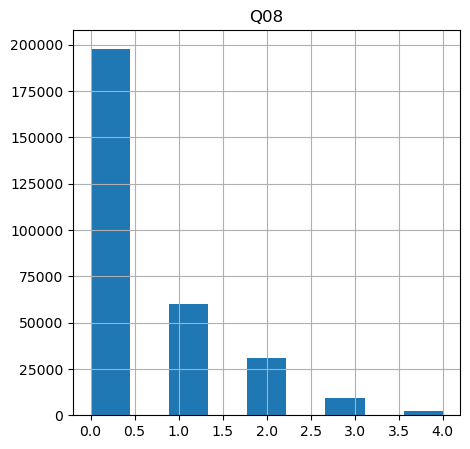

In [ ]:
# Looking at the distribution of the answers about SI
import matplotlib.pyplot as plt

si.hist(bins=9, figsize=(5, 5))
plt.show()

In [ ]:
# Randomly selecting 67 rows from oq Q08

# set seed

np.random.seed(0)

si = si.sample(68).reset_index(drop=True)

samples = samples.reset_index(drop=True)

# adding si to samples as a new column called SI
samples["SI"] = si

print(samples["SI"].isnull().sum())
samples.head()

0


,gen-anonymized,past_thoughts_about_death,past_thoughts_about_ways_to_die,past_attempts_to_try_to_die,past_hospitalizations_because_of_SI_or_SA,how_recent_in_the_past_week_were_thoughts_about_death,how_recent_in_the_past_week_were_thoughts_about_ways_to_die,how_recent_in_the_past_week_were_past_attempts_to_try_to_die,how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA,current_thoughts_about_death,...,death_of_close_relationship_esp_from_suicide,fear_of_punishment,anticipated_loss_of_financial_security,fear_of_becoming_burden_to_others,?Self_critical_thoughts?,?Frustration?,?Conflict_with_close_relationship?,?Physical_pain?,recency,SI
0,"Description of Client: xxxx is a xx-year-old, ...",0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0.0
1,"xxxx is a xxxx yr old female, caucasian, from ...",0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,0,0,0,1,0,0,0,0,0.0
2,Client came in and talked about some more worr...,0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,0,0,1,0,0,0,0,0,0.0
3,xxxx processed his feelings about the break-up...,0,0,0,0,NaN,NaN,NaN,NaN,0,...,0,1,0,0,1,0,0,0,0,1.0
4,"Description of Client: xxxxx is xxx years old,...",0,0,0,0,NaN,NaN,NaN,NaN,0,...,1,0,0,0,0,0,0,0,0,2.0


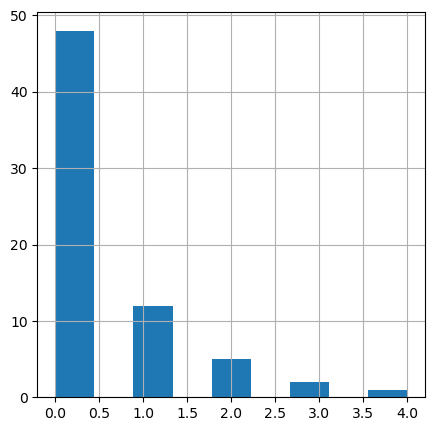

In [ ]:
samples["SI"].hist(bins=9, figsize=(5, 5))
plt.show()

In [ ]:
# looks great, saving to a new dataframe and file

samples.to_csv("../Data/labeled_samples_for_model.csv", index=False)

#### The code below here is where I short through the data for examples I can use in my slides

In [ ]:
# Finding an example I can use in my slides that is short but demonstrates several of the features
df = pd.read_csv("../Data/extract_merged_withOQ_text.csv")

df.columns

Index(['row_x', 'ID_x', 'AppointID', 'gen-anonymized', 'row_y', 'ID_y',
       'past_thoughts_about_death', 'past_thoughts_about_ways_to_die',
       'past_attempts_to_try_to_die',
       'past_hospitalizations_because_of_SI_or_SA',
       'current_thoughts_about_death', 'current_thoughts_about_ways_to_die',
       'current_intent_to_try_to_die',
       'client_acquiring_means_to_try_to_kill_themselves',
       'cooccuring_mental_health_symptoms', 'pornography_use',
       'anger_aggression_irritability', 'possibility_of_being_fired_expelled',
       'loss_of_major_relationship',
       'death_of_close_relationship_esp_from_suicide', 'fear_of_punishment',
       'anticipated_loss_of_finullcial_security',
       'fear_of_becoming_burden_to_others', '?Self_critical_thoughts?',
       '?Frustration?', '?Conflict_with_close_relationship?',
       '?Physical_pain?', 'recency',
       'how_recent_in_the_past_week_were_thoughts_about_death',
       'how_recent_in_the_past_week_were_thoughts_a

In [ ]:
# Find rows in df where 'gen-anonymized' is less than 50 characters and at least three of the 6th-indexed column and after have the value 1

short_examples = df[df["gen-anonymized"].str.len() < 300]

# Checking the number of rows in short_examples
print(len(short_examples))

# Now filtering for rows where at least three of the columns from the 6th index onward have the value 1
filtered_examples = short_examples[(short_examples.iloc[:, 5:] == 1).sum(axis=1) >= 4]

# Checking the number of rows in filtered_examples
print(len(filtered_examples))

# Displaying the filtered examples
filtered_examples

92
1


,row_x,ID_x,AppointID,gen-anonymized,row_y,ID_y,past_thoughts_about_death,past_thoughts_about_ways_to_die,past_attempts_to_try_to_die,past_hospitalizations_because_of_SI_or_SA,...,?Self_critical_thoughts?,?Frustration?,?Conflict_with_close_relationship?,?Physical_pain?,recency,how_recent_in_the_past_week_were_thoughts_about_death,how_recent_in_the_past_week_were_thoughts_about_ways_to_die,how_recent_in_the_past_week_were_past_attempts_to_try_to_die,how_recent_in_the_past_week_were_past_hospitalizations_of_SI_or_SA,OQ_8
613,16198,46355682.0,100909.0,xxxx reported that he continues to have suici...,613,46355682.0,1,0,0,0,...,0,0,0,0,1,continues,NaN,NaN,NaN,2.0


In [ ]:
# finding all rows with a 1 in column index 20 and then finding the row with the shortest length of 'gen-anonymized'
fop = df[df.iloc[:, 20] == 1]

# Finding the row in fop with the shortest length of 'gen-anonymized'

shortest_row = fop.loc[fop["gen-anonymized"].str.len().idxmin()]
shortest_row

row_x                                                                                                            250336
ID_x                                                                                                        836180367.0
AppointID                                                                                                      110391.0
gen-anonymized                                                        I suggested that xxxx continue to work to deca...
row_y                                                                                                               423
ID_y                                                                                                        836180367.0
past_thoughts_about_death                                                                                             0
past_thoughts_about_ways_to_die                                                                                       0
past_attempts_to_try_to_die             